## Notes

When building XGBoost trees, we calculate the similarity scores and gain to determine how to split the data, we then prune the tree by calculating the differences between Gain values and a user definied tree complexity parameter, gamma. If gain - gamma = -ve, we prune, otherwise no change.

Note: Lamda is a regularization parameter and when lamda > 0, it results in more pruning as it shrinks the similarity scores and resulrs in smaller output values for the leaves

Output value = sum of residuals/number of residuals + lamda

Similarity score = sum of residuals, squared/ number of residuals + 1

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sb.set()

In [2]:
df = pd.read_csv("student-por.csv", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

## One-Hot Encoding

Taking data that is categorical and splitting it into useable data types. EXMP: Medu has categories 0-4, using one-hot encoding allows for the data to be represented as 5 seperate columns of Medu_0, Medu_1, Medu_2, Medu_3, Medu_4

In [3]:
y = pd.DataFrame((df['G3'] >= 10).replace({True: 1, False: 0}))
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   G3      649 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [4]:
df = df.drop('G3', axis=1).copy()

In [5]:
df['age'] = df['age'].astype(object)
df['Medu'] = df['Medu'].astype(object)
df['Fedu'] = df['Fedu'].astype(object)
df['traveltime'] = df['traveltime'].astype(object)
df['studytime'] = df['studytime'].astype(object)
df['famrel'] = df['famrel'].astype(object)
df['freetime'] = df['freetime'].astype(object)
df['goout'] = df['goout'].astype(object)
df['Dalc'] = df['Dalc'].astype(object)
df['Walc'] = df['Walc'].astype(object)
df['health'] = df['health'].astype(object)

df['failures'] = df['failures'].astype(float)
df['absences'] = df['absences'].astype(float)
df['G1'] = df['G1'].astype(float)
df['G2'] = df['G2'].astype(float)

In [6]:
df.dtypes

school         object
sex            object
age            object
address        object
famsize        object
Pstatus        object
Medu           object
Fedu           object
Mjob           object
Fjob           object
reason         object
guardian       object
traveltime     object
studytime      object
failures      float64
schoolsup      object
famsup         object
paid           object
activities     object
nursery        object
higher         object
internet       object
romantic       object
famrel         object
freetime       object
goout          object
Dalc           object
Walc           object
health         object
absences      float64
G1            float64
G2            float64
dtype: object

In [7]:
tempDF = pd.DataFrame(df[['Medu', 'Mjob','Fedu' ,'studytime', 'higher', 'internet', 'Dalc', 'Walc', 'failures', 'absences', 'G1', 'G2']])
tempDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Medu       649 non-null    object 
 1   Mjob       649 non-null    object 
 2   Fedu       649 non-null    object 
 3   studytime  649 non-null    object 
 4   higher     649 non-null    object 
 5   internet   649 non-null    object 
 6   Dalc       649 non-null    object 
 7   Walc       649 non-null    object 
 8   failures   649 non-null    float64
 9   absences   649 non-null    float64
 10  G1         649 non-null    float64
 11  G2         649 non-null    float64
dtypes: float64(4), object(8)
memory usage: 61.0+ KB


In [8]:
X_encoded = pd.get_dummies(tempDF, columns=['Medu', 'Mjob','Fedu' ,'studytime', 'higher', 'internet', 'Dalc', 'Walc'])

X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   failures       649 non-null    float64
 1   absences       649 non-null    float64
 2   G1             649 non-null    float64
 3   G2             649 non-null    float64
 4   Medu_0         649 non-null    uint8  
 5   Medu_1         649 non-null    uint8  
 6   Medu_2         649 non-null    uint8  
 7   Medu_3         649 non-null    uint8  
 8   Medu_4         649 non-null    uint8  
 9   Mjob_at_home   649 non-null    uint8  
 10  Mjob_health    649 non-null    uint8  
 11  Mjob_other     649 non-null    uint8  
 12  Mjob_services  649 non-null    uint8  
 13  Mjob_teacher   649 non-null    uint8  
 14  Fedu_0         649 non-null    uint8  
 15  Fedu_1         649 non-null    uint8  
 16  Fedu_2         649 non-null    uint8  
 17  Fedu_3         649 non-null    uint8  
 18  Fedu_4    

C:\Users\User\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


## Applying XGBoost model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.25)

In [18]:
clf_xgb = xgb.XGBClassifier(seed=42,objective='binary:logistic',gamma=0.25,learn_rate=0.1,max_depth=4,reg_lambda=10,scale_pos_weight=3,subsample=0.9,colsample_bytree=0.5)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[17:39:14] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learn_rate" } are not used.

[0]	validation_0-aucpr:0.92311
[1]	validation_0-aucpr:0.94429
[2]	validation_0-aucpr:0.97668
[3]	validation_0-aucpr:0.97757
[4]	validation_0-aucpr:0.97733
[5]	validation_0-aucpr:0.97744
[6]	validation_0-aucpr:0.97602
[7]	validation_0-aucpr:0.97577
[8]	validation_0-aucpr:0.98158
[9]	validation_0-aucpr:0.98171
[10]	validation_0-aucpr:0.98185
[11]	validation_0-aucpr:0.98784
[12]	validation_0-aucpr:0.98834
[13]	validation_0-aucpr:0.98848
[14]	validation_0-aucpr:0.98904
[15]	validation_0-aucpr:0.99022
[16]	validation_0-aucpr:0.99054
[17]	validation_0-aucpr:0.99077
[18]	validation_0-aucpr:0.99076
[19]	validation_0-aucpr:0.99104
[20]	validation_0-aucpr:0.99097
[21]	validation_0-aucpr:0.99069
[22]	validation_0-aucpr:0.99061
[23]	validation_0-aucpr:0.99065
[24]	validation_0-aucpr:0.99070
[25]	validation_0-aucpr:0.99057
[26]	validation_0-aucpr:0.99058
[2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learn_rate=0.1, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

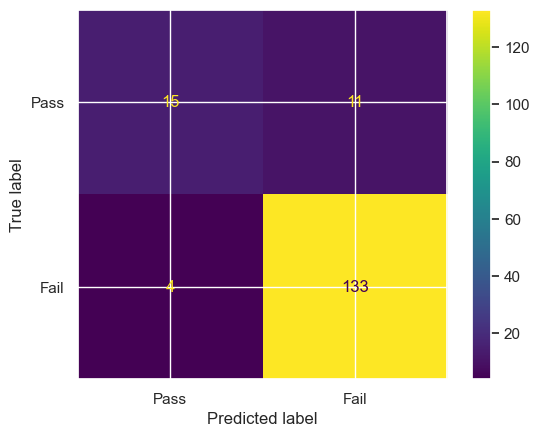

In [19]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', display_labels=["Pass", "Fail"])